In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import random
import torch.backends.cudnn as cudnn

from tqdm import tqdm

import matplotlib.pyplot as plt

DATA_DIR = os.path.join('..', 'Data')
MOVIE_DATA = os.path.join(DATA_DIR, 'ml-latest-small', 'ratings.csv')

c:\Users\temp\miniconda3\envs\rec\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random_seed = 42

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
np.random.seed(random_seed)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(random_seed)

# 1. Data Preprocessing

In [3]:
def get_movie_df() -> pd.DataFrame:
    """
    read movie data and return data frame
        colmns: user, movie, rating
    """
    movie_raw_df = pd.read_csv(MOVIE_DATA)
    movie_raw_df.drop(labels='timestamp', axis=1, inplace=True)
    movie_raw_df.rename(columns={'userId': 'user', 'movieId': 'movie'}, inplace=True)

    return movie_raw_df

In [4]:
def encode(df: pd.DataFrame) -> tuple[pd.DataFrame, LabelEncoder, LabelEncoder]:
    """
    encode and return user and movie
    """

    user_encoder = LabelEncoder()
    movie_encoder = LabelEncoder()

    df['user'] = user_encoder.fit_transform(df['user'].values)
    df['movie'] = movie_encoder.fit_transform(df['movie'].values)

    return df, user_encoder, movie_encoder

# 2. Dataset

In [5]:
class MFDataset(Dataset):
    def __init__(self, df, train, train_size) -> None:
        
        self._all_df = df
        self.num_user = len(self._all_df['user'].unique())
        self.num_movie = len(self._all_df['movie'].unique())

        self.data = self._data_split(train, train_size)

    def _data_split(self, train, train_size):
        train_data, test_data = train_test_split(
            self._all_df, 
            test_size=1-train_size, 
            train_size=train_size, 
            stratify=self._all_df['user'].values, 
            random_state=random_seed)

        if train:
            return train_data
        else:
            return test_data
    
    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index) -> tuple[torch.tensor, torch.tensor]:
        user = torch.tensor(self.data.iloc[index].user).int()
        movie = torch.tensor(self.data.iloc[index].movie).int()
        rating = torch.tensor(self.data.iloc[index].rating).float()
        return user, movie, rating


def get_dataloader(df, train=True, train_size=0.8, batch_size=512):
    """
    make dataset, dataloader and return dataloader
    """
    dataset = MFDataset(df, train, train_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=train, drop_last=False)

    return dataloader

# 3. Model

In [6]:
class MF(nn.Module):
    def __init__(self, num_user: int, num_movie: int, dim: int, mu) -> None:
        super(MF, self).__init__()
        
        self.user_embeddings = nn.Embedding(num_user, dim)
        self.movie_embeddings = nn.Embedding(num_movie, dim)
        self.user_bias = nn.Embedding(num_user, 1)
        self.movie_bias = nn.Embedding(num_movie, 1)
        self.mu = mu

        self._init_weights()
    
    def _init_weights(self):
        self.user_embeddings.weight.data.normal_(0, 1.0 / self.user_embeddings.embedding_dim)
        self.movie_embeddings.weight.data.normal_(0, 1.0 / self.movie_embeddings.embedding_dim)
        self.user_bias.weight.data.normal_(0, 1.0 / self.movie_embeddings.embedding_dim)
        self.movie_bias.weight.data.normal_(0, 1.0 / self.movie_embeddings.embedding_dim)
    
    def forward(self, user: int, movie: int) -> float:
        user_embed = self.user_embeddings(user)
        movie_embed = self.movie_embeddings(movie)
        user_bias = self.user_bias(user)
        movie_bias = self.movie_bias(movie)

        outputs = (torch.sum(user_embed * movie_embed, axis=1) + 
            torch.squeeze(user_bias) + torch.squeeze(movie_bias) + self.mu)

        return outputs

# 4. train, test, plot func

In [7]:
def train(model, train_loader, criterion, optimizer, device):
    model.to(device)
    criterion.to(device)

    model.train()
    total_train_loss = 0

    for user, movie, rating in tqdm(train_loader):
        user = user.to(device)
        movie = movie.to(device)
        rating = rating.to(device)

        predict = model(user, movie)

        train_loss = criterion(predict, rating)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        total_train_loss += train_loss.item()
    
    loss_avg = total_train_loss / len(train_loader)

    return loss_avg

In [8]:
def test(model, test_loader, criterion, device):
    model.to(device)
    criterion.to(device)
    model.eval()

    total_test_loss = 0
    with torch.no_grad():
        for user, movie, rating in tqdm(test_loader):
            user = user.to(device)
            movie = movie.to(device)
            rating = rating.to(device)

            predict = model(user, movie)
            test_loss = criterion(predict, rating)

            total_test_loss += test_loss.item()

    return total_test_loss / len(test_loader)

In [9]:
def plot_loss(epochs, train_losses, test_losses, model_name):
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    fig.suptitle(model_name, fontsize=30)
    x = [i for i in range(1, epochs+1)]

    ax.plot(x, train_losses,
          label='train loss')
    ax.plot(x, test_losses,
            label='test_loss')

    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.set_title('MSE')
    ax.legend()

    ax.spines['top'].set_visible(False) # 위 테두리 안 보이게
    ax.spines['right'].set_visible(False) # 오른쪽 테두리 안 보이게

    plt.show()

# 5. Set config

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"user {device}")

movie_df = get_movie_df()
movie_df, user_encoder, movie_encoder = encode(movie_df)

mu = movie_df['rating'].mean()

num_user = movie_df['user'].nunique()
num_movie = movie_df['movie'].nunique()
dim = 10

model = MF(num_user, num_movie, dim, mu)

train_loader = get_dataloader(movie_df, train=True)
test_loader = get_dataloader(movie_df, train=False)

num_epoch = 20
learning_rate = 1e-3 # gamma in paper
weight_decay = 1e-6 # regularization in paper
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

user cuda:0


# 6. Do train, test, plot

In [11]:
train_losses = []
test_losses = []

for epoch in range(num_epoch):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    test_loss = test(model, test_loader, criterion, device)
    test_losses.append(test_loss)

    print(f'epoch: {epoch + 1}, train Loss: {train_loss:.4f}, test Loss: {test_loss:.4f}')

100%|██████████| 40/40 [00:06<00:00,  6.20it/s]


epoch: 1, train Loss: 1.0609, test Loss: 1.0155


100%|██████████| 40/40 [00:06<00:00,  6.14it/s]


epoch: 2, train Loss: 0.9846, test Loss: 0.9616


100%|██████████| 40/40 [00:06<00:00,  6.11it/s]


epoch: 3, train Loss: 0.9223, test Loss: 0.9204


100%|██████████| 40/40 [00:06<00:00,  6.13it/s]


epoch: 4, train Loss: 0.8691, test Loss: 0.8879


100%|██████████| 40/40 [00:06<00:00,  6.15it/s]


epoch: 5, train Loss: 0.8192, test Loss: 0.8613


100%|██████████| 40/40 [00:06<00:00,  6.19it/s]


epoch: 6, train Loss: 0.7689, test Loss: 0.8389


100%|██████████| 40/40 [00:06<00:00,  6.03it/s]


epoch: 7, train Loss: 0.7184, test Loss: 0.8206


100%|██████████| 40/40 [00:06<00:00,  6.18it/s]


epoch: 8, train Loss: 0.6696, test Loss: 0.8067


100%|██████████| 40/40 [00:06<00:00,  6.17it/s]


epoch: 9, train Loss: 0.6252, test Loss: 0.7975


100%|██████████| 40/40 [00:06<00:00,  6.12it/s]


epoch: 10, train Loss: 0.5859, test Loss: 0.7927


100%|██████████| 40/40 [00:06<00:00,  6.15it/s]


epoch: 11, train Loss: 0.5520, test Loss: 0.7911


100%|██████████| 40/40 [00:06<00:00,  6.20it/s]


epoch: 12, train Loss: 0.5231, test Loss: 0.7921


100%|██████████| 40/40 [00:06<00:00,  6.20it/s]


epoch: 13, train Loss: 0.4980, test Loss: 0.7945


100%|██████████| 40/40 [00:06<00:00,  6.15it/s]


epoch: 14, train Loss: 0.4760, test Loss: 0.7984


100%|██████████| 40/40 [00:06<00:00,  6.09it/s]


epoch: 15, train Loss: 0.4576, test Loss: 0.8030


100%|██████████| 40/40 [00:06<00:00,  6.06it/s]


epoch: 16, train Loss: 0.4408, test Loss: 0.8081


100%|██████████| 40/40 [00:06<00:00,  6.02it/s]


epoch: 17, train Loss: 0.4262, test Loss: 0.8135


100%|██████████| 40/40 [00:06<00:00,  6.14it/s]


epoch: 18, train Loss: 0.4129, test Loss: 0.8190


100%|██████████| 40/40 [00:06<00:00,  6.16it/s]


epoch: 19, train Loss: 0.4013, test Loss: 0.8246


100%|██████████| 40/40 [00:06<00:00,  6.13it/s]

epoch: 20, train Loss: 0.3908, test Loss: 0.8302


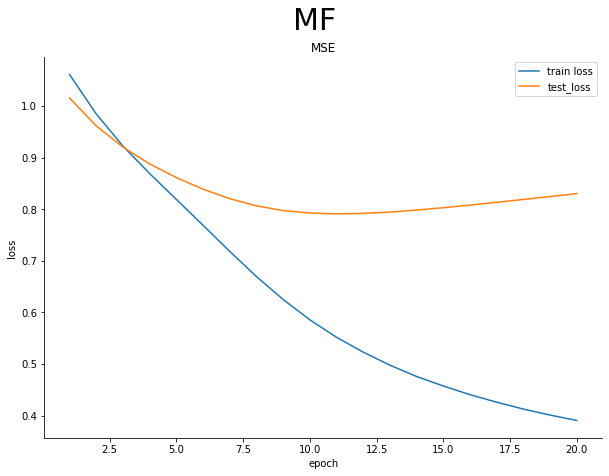

In [12]:
plot_loss(num_epoch, train_losses, test_losses, 'MF')